# **Aura Najma Kustiananda | 164221053**

## Import Library dan Dataset

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import librosa
import wave
import os
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd


In [2]:
np.random.seed(42)
folder_path = './data datmin ii/heartbeat sounds'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
labels_and_files = []

for file in file_list:
    wav_file = wave.open(os.path.join(folder_path, file), 'rb')
    label = file.split('_')[0] 
    labels_and_files.append((label, file, wav_file))
    print(f"Label: {label}, File: {file}")

df_labels_and_files = pd.DataFrame(labels_and_files, columns=['Label', 'FileName', 'WavFile'])


Label: artifact, File: artifact__201012172012.wav
Label: artifact, File: artifact__201105040918.wav
Label: artifact, File: artifact__201105041959.wav
Label: artifact, File: artifact__201105051017.wav
Label: artifact, File: artifact__201105060108.wav
Label: artifact, File: artifact__201105061143.wav
Label: artifact, File: artifact__201105190800.wav
Label: artifact, File: artifact__201105280851.wav
Label: artifact, File: artifact__201106010559.wav
Label: artifact, File: artifact__201106010602.wav
Label: artifact, File: artifact__201106021541.wav
Label: artifact, File: artifact__201106030612.wav
Label: artifact, File: artifact__201106031558.wav
Label: artifact, File: artifact__201106040722.wav
Label: artifact, File: artifact__201106040933.wav
Label: artifact, File: artifact__201106040947.wav
Label: artifact, File: artifact__201106041452.wav
Label: artifact, File: artifact__201106050353.wav
Label: artifact, File: artifact__201106061233.wav
Label: artifact, File: artifact__201106070537.wav


In [3]:
df_labels_and_files.head()

Label                    FileName  \
0  artifact  artifact__201012172012.wav   
1  artifact  artifact__201105040918.wav   
2  artifact  artifact__201105041959.wav   
3  artifact  artifact__201105051017.wav   
4  artifact  artifact__201105060108.wav   

                                         WavFile  
0  <wave.Wave_read object at 0x0000019BADB73990>  
1  <wave.Wave_read object at 0x0000019BD0A0A2D0>  
2  <wave.Wave_read object at 0x0000019BD12D5090>  
3  <wave.Wave_read object at 0x0000019BD12D51D0>  
4  <wave.Wave_read object at 0x0000019BD12D5350>

In [4]:
df_labels_and_files['Label'].value_counts()

Label
normal             351
Bunlabelledtest    195
murmur             129
Aunlabelledtest     52
extrastole          46
artifact            40
extrahls            19
Name: count, dtype: int64

In [5]:
df_unused = df_labels_and_files[df_labels_and_files['Label'].isin(['Bunlabelledtest', 'Aunlabelledtest'])].reset_index(drop=True)
df = df_labels_and_files[~df_labels_and_files['Label'].isin(['Bunlabelledtest', 'Aunlabelledtest'])].reset_index(drop=True)

print("Jumlah data tidak terpakai:", df_unused.shape[0])
print("Jumlah data terpakai:", df.shape[0])

print("Distribusi label dalam data tidak terpakai:")
print(df_unused['Label'].value_counts())

print("Distribusi label dalam data terpakai:")
print(df['Label'].value_counts())


Jumlah data tidak terpakai: 247
Jumlah data terpakai: 585
Distribusi label dalam data tidak terpakai:
Label
Bunlabelledtest    195
Aunlabelledtest     52
Name: count, dtype: int64
Distribusi label dalam data terpakai:
Label
normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

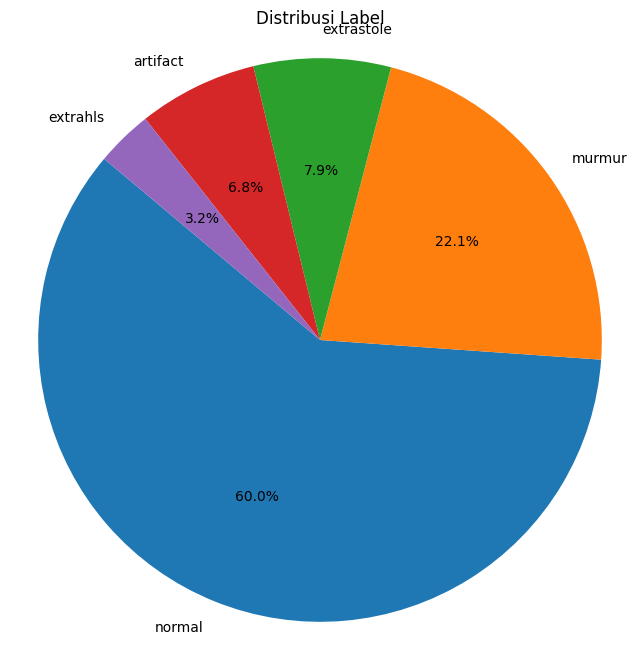

In [6]:
label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Label')
plt.axis('equal')  
plt.show()


C:\Users\Acer\AppData\Local\Temp\ipykernel_28656\502000962.py:4: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=address)


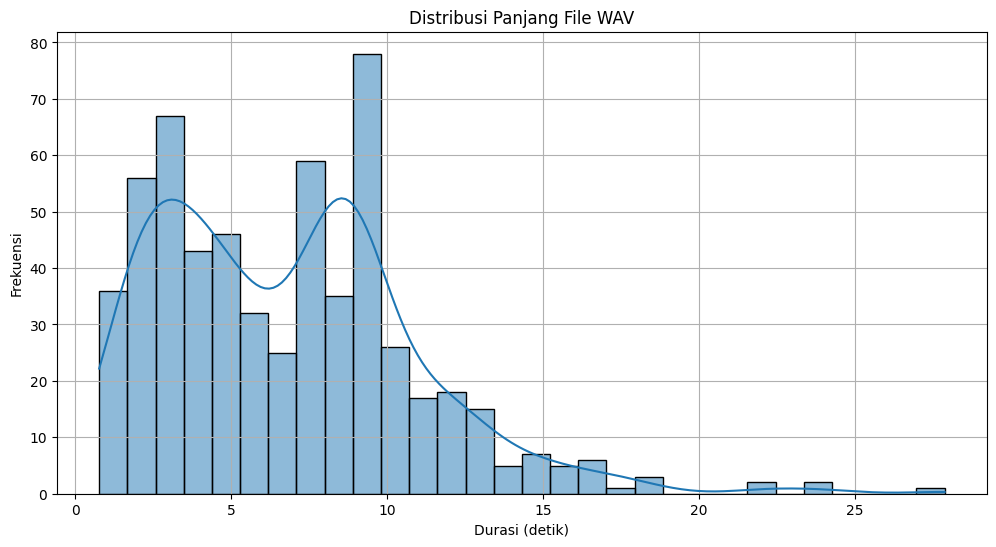

In [7]:
def get_wav_duration(file_name):
    address = os.path.join(folder_path, file_name)
    try:
        duration = librosa.get_duration(filename=address)
        return duration
    except Exception as e:
        print(f"Error loading {address}: {e}")
        return np.nan  
df['Duration'] = df['FileName'].apply(get_wav_duration)

plt.figure(figsize=(12, 6))
sns.histplot(df['Duration'], bins=30, kde=True)
plt.title('Distribusi Panjang File WAV')
plt.xlabel('Durasi (detik)')
plt.ylabel('Frekuensi')
plt.grid()
plt.show()

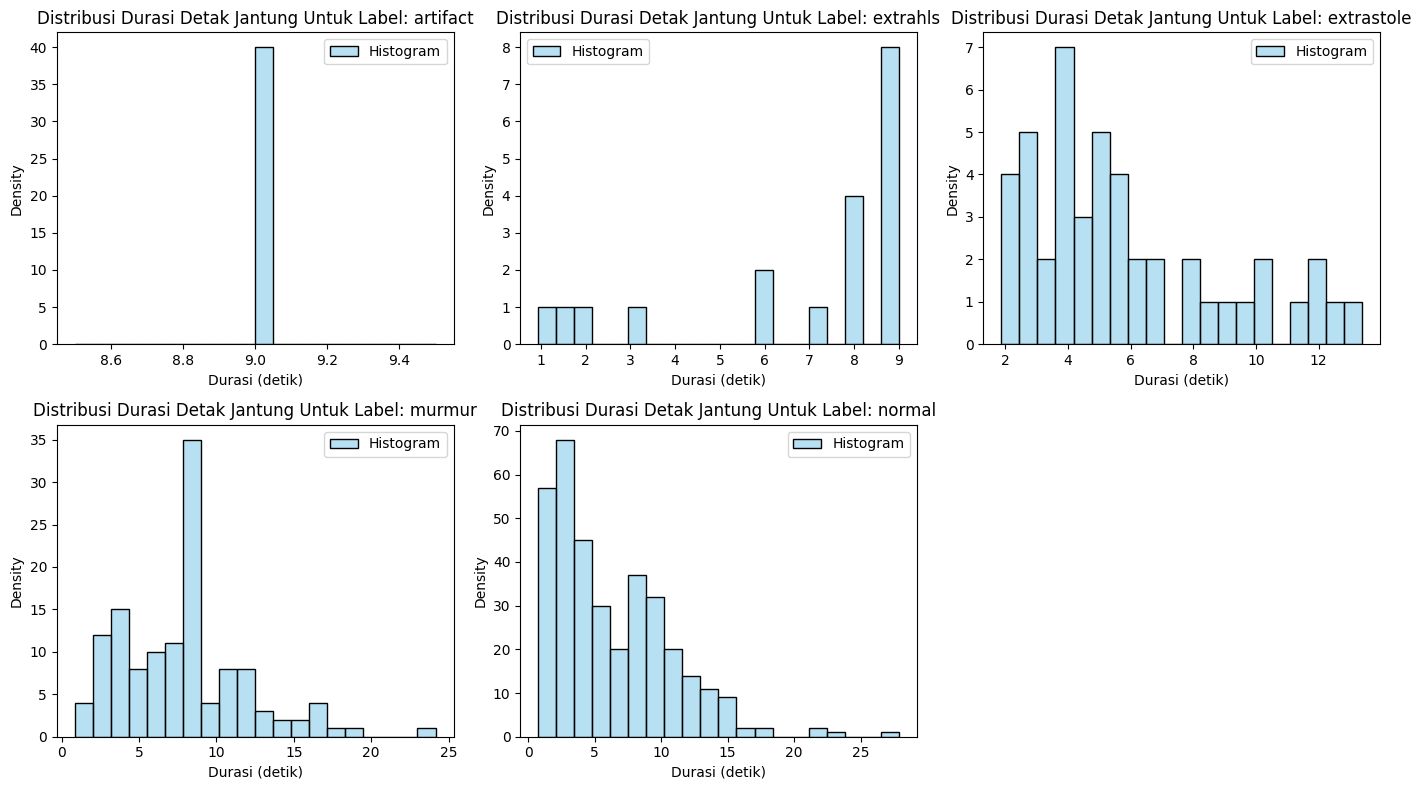

In [8]:
plt.figure(figsize=(14, 8))

labels = df['Label'].unique()
for i, label in enumerate(labels, 1):
    plt.subplot(2, (len(labels) + 1) // 2, i)  
    label_data = df[df['Label'] == label]['Duration']
    sns.histplot(label_data, kde=False, color='skyblue', bins=20, alpha=0.6, label='Histogram')
    plt.title(f'Distribusi Durasi Detak Jantung Untuk Label: {label}')
    plt.xlabel('Durasi (detik)')
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

In [9]:
def plot_waveform(audio_signal, sample_rate):
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(audio_signal, sr=sample_rate)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

def plot_spectrum(audio_signal, sample_rate):
    spectrum = np.fft.fft(audio_signal)
    frequency = np.fft.fftfreq(len(spectrum), d=1/sample_rate)
    magnitude = np.abs(spectrum)
    frequency = frequency[:len(frequency)//2]
    magnitude = magnitude[:len(magnitude)//2]

    plt.figure(figsize=(15, 5))
    plt.plot(frequency, magnitude)
    plt.title('Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.xlim(0, 2000)  
    plt.show()

def plot_spectrogram(audio_signal, sample_rate):
    plt.figure(figsize=(15, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_signal)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()



In [10]:
def visualize_random_normal_sample(df):
    normal_df = df[df['Label'] == 'normal']
    
    if normal_df.empty:
        print("Tidak ada data dengan label 'normal'.")
        return None, None, None
    
    random_index = np.random.randint(0, len(normal_df))
    random_row = normal_df.iloc[random_index]
    sample_label = random_row['Label']
    sample_file_name = random_row['FileName']
    sample_address = os.path.join(folder_path, sample_file_name)  
    sample_sound, sample_rate = librosa.load(sample_address)
    sample_audio = ipd.Audio(sample_sound, rate=sample_rate)
    
    return sample_audio, sample_label, sample_sound, sample_rate

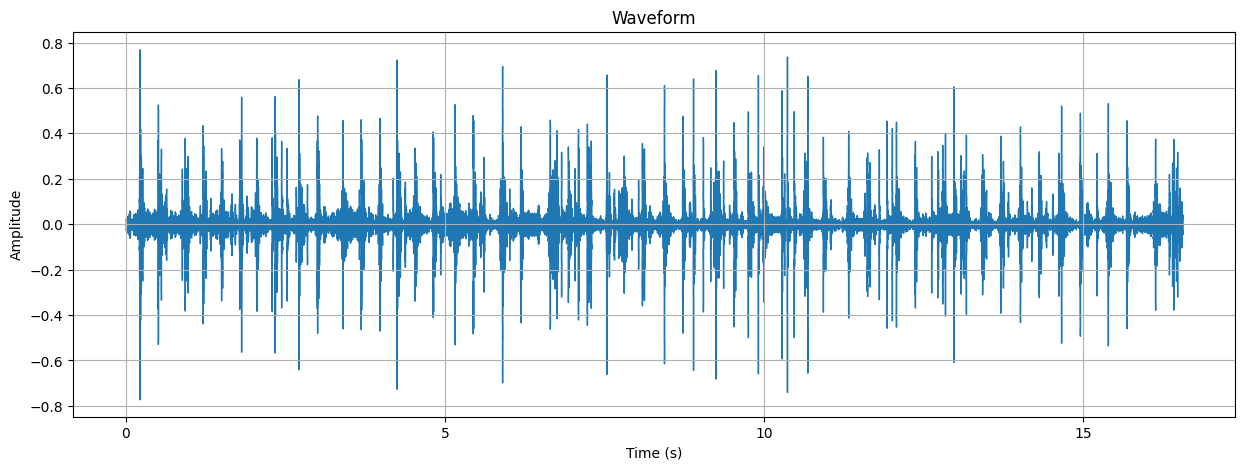

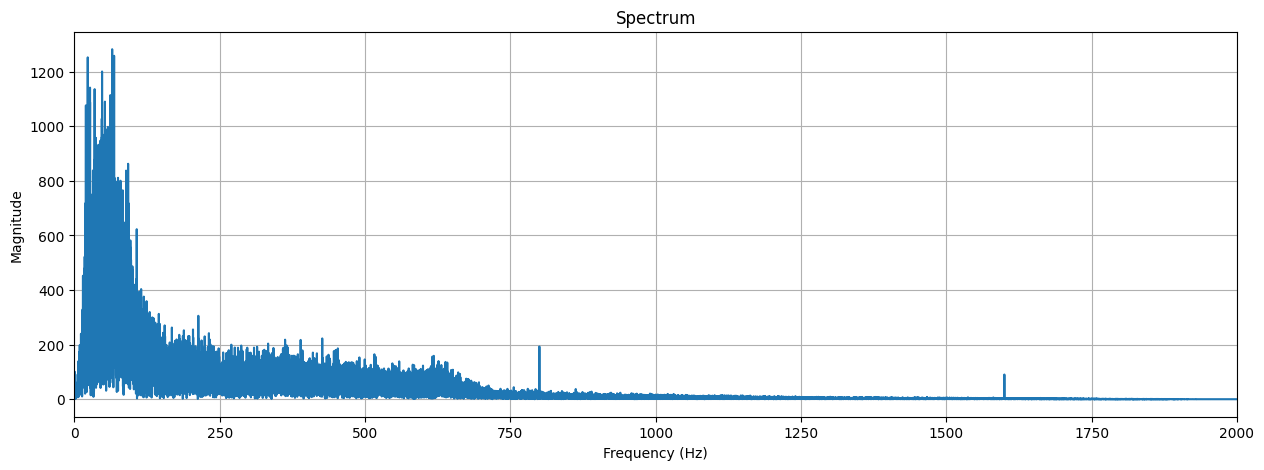

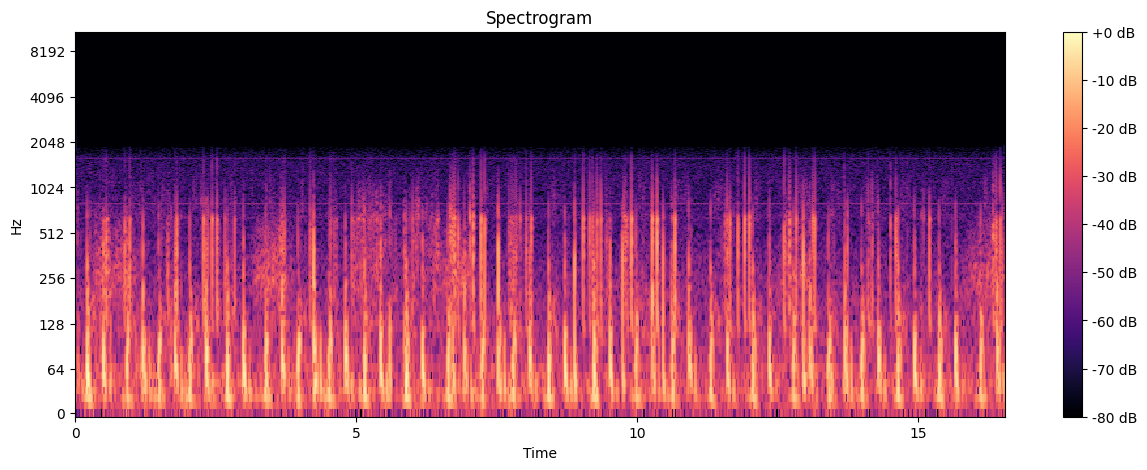

In [11]:
sample_normal_audio, sample_normal_label, sample_normal_sound, sample_normal_rate = visualize_random_normal_sample(df)

display(sample_normal_audio)
plot_waveform(sample_normal_sound, sample_normal_rate)
plot_spectrum(sample_normal_sound, sample_normal_rate)  
plot_spectrogram(sample_normal_sound, sample_normal_rate)  


In [12]:
def visualize_random_extrahls_sample(df):
    extrahls_df = df[df['Label'] == 'extrahls']
    
    if extrahls_df.empty:
        print("Tidak ada data dengan label 'extrahls'.")
        return None, None, None
    
    random_index = np.random.randint(0, len(extrahls_df))
    random_row = extrahls_df.iloc[random_index]
    sample_label = random_row['Label']
    sample_file_name = random_row['FileName']
    sample_address = os.path.join(folder_path, sample_file_name)
    sample_sound, sample_rate = librosa.load(sample_address)
    sample_audio = ipd.Audio(sample_sound, rate=sample_rate)
    
    return sample_audio, sample_label, sample_sound, sample_rate

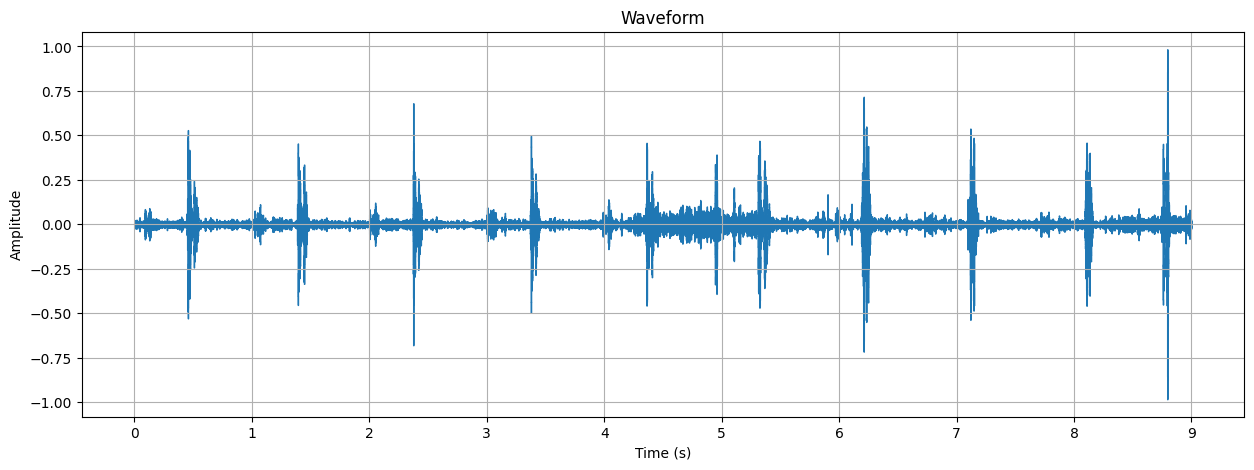

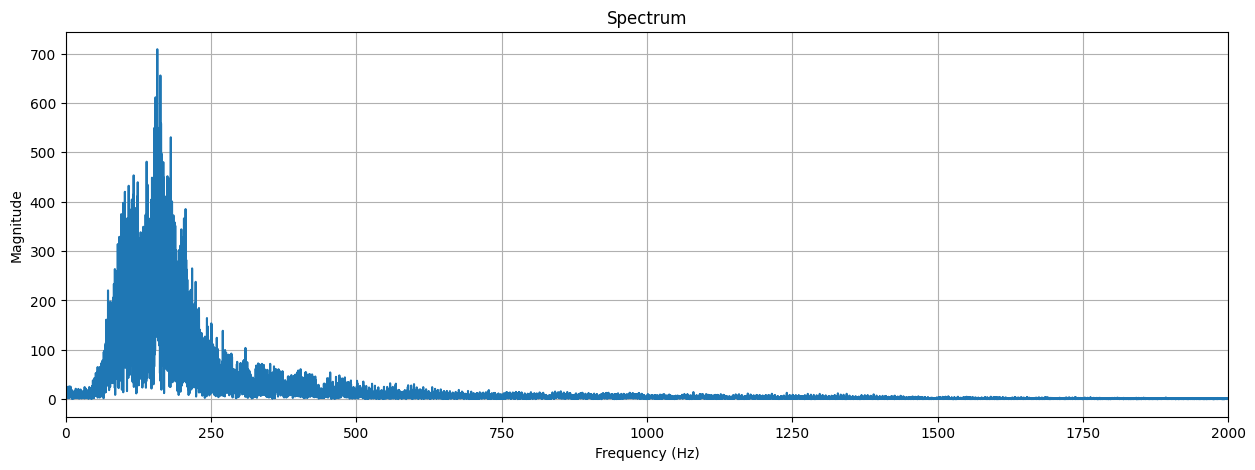

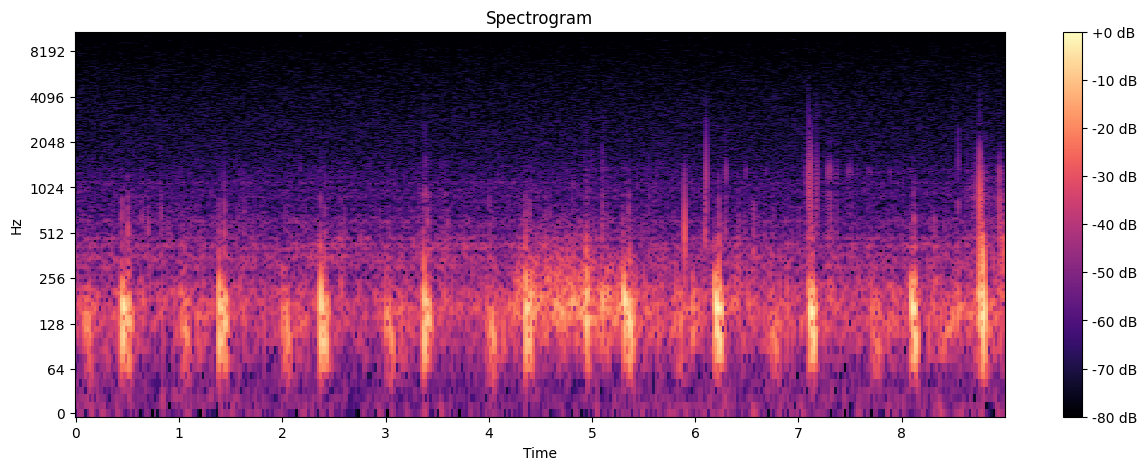

In [13]:
sample_extrahls_audio, sample_extrahls_label, sample_extrahls_sound, sample_extrahls_rate = visualize_random_extrahls_sample(df)

display(sample_extrahls_audio)
plot_waveform(sample_extrahls_sound, sample_extrahls_rate)
plot_spectrum(sample_extrahls_sound, sample_extrahls_rate) 
plot_spectrogram(sample_extrahls_sound, sample_extrahls_rate)  

In [14]:
def visualize_random_murmur_sample(df):
    murmur_df = df[df['Label'] == 'murmur']
    
    if murmur_df.empty:
        print("Tidak ada data dengan label 'murmur'.")
        return None, None, None
    
    random_index = np.random.randint(0, len(murmur_df))
    random_row = murmur_df.iloc[random_index]
    sample_label = random_row['Label']
    sample_file_name = random_row['FileName']
    sample_address = os.path.join(folder_path, sample_file_name)  
    sample_sound, sample_rate = librosa.load(sample_address)
    sample_audio = ipd.Audio(sample_sound, rate=sample_rate)
    
    return sample_audio, sample_label, sample_sound, sample_rate

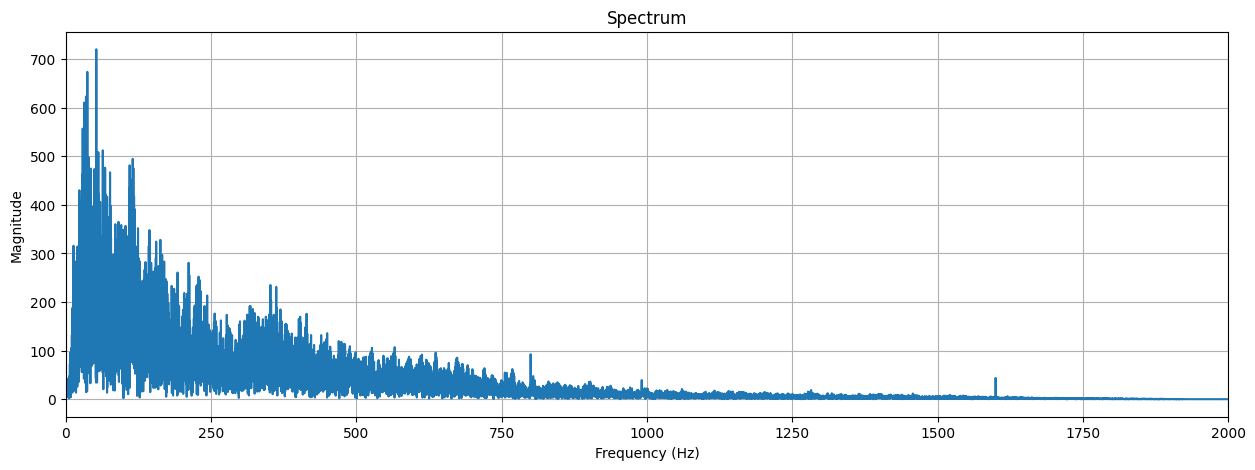

In [15]:
sample_murmur_audio, sample_murmur_label, sample_murmur_sound, sample_murmur_rate = visualize_random_murmur_sample(df)

if sample_murmur_audio is not None:
    display(sample_murmur_audio)  
    plot_waveform(sample_murmur_sound, sample_murmur_rate)  
    plot_spectrum(sample_murmur_sound, sample_murmur_rate)  
    plot_spectrogram(sample_murmur_sound, sample_murmur_rate)  

In [16]:
def visualize_random_extrastole_sample(df):
    extrastole_df = df[df['Label'] == 'extrastole']
    
    if extrastole_df.empty:
        print("Tidak ada data dengan label 'extrastole'.")
        return None, None, None
    
    random_index = np.random.randint(0, len(extrastole_df))
    random_row = extrastole_df.iloc[random_index]
    sample_label = random_row['Label']
    sample_file_name = random_row['FileName']
    sample_address = os.path.join(folder_path, sample_file_name)  
    sample_sound, sample_rate = librosa.load(sample_address)
    sample_audio = ipd.Audio(sample_sound, rate=sample_rate)
    
    return sample_audio, sample_label, sample_sound, sample_rate

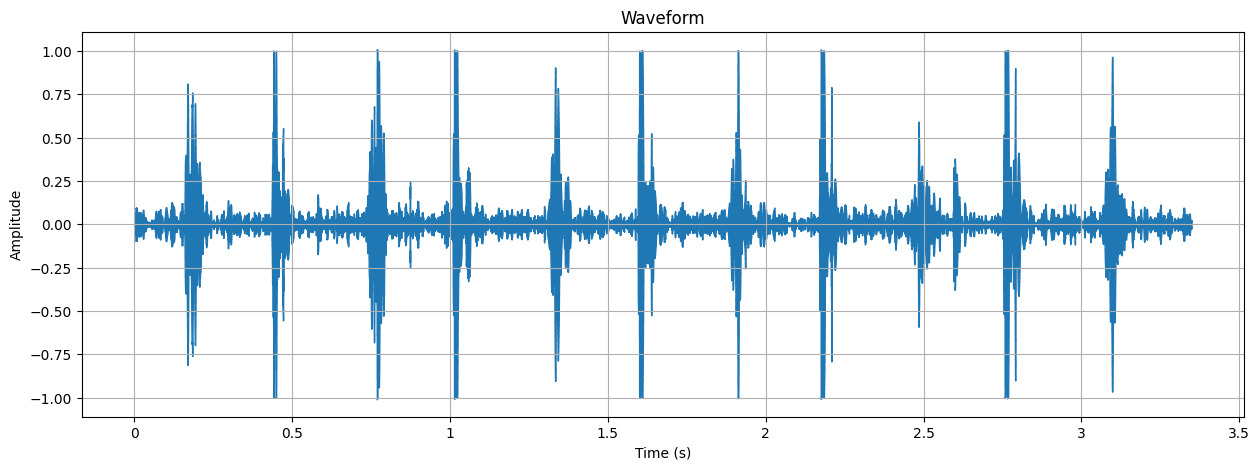

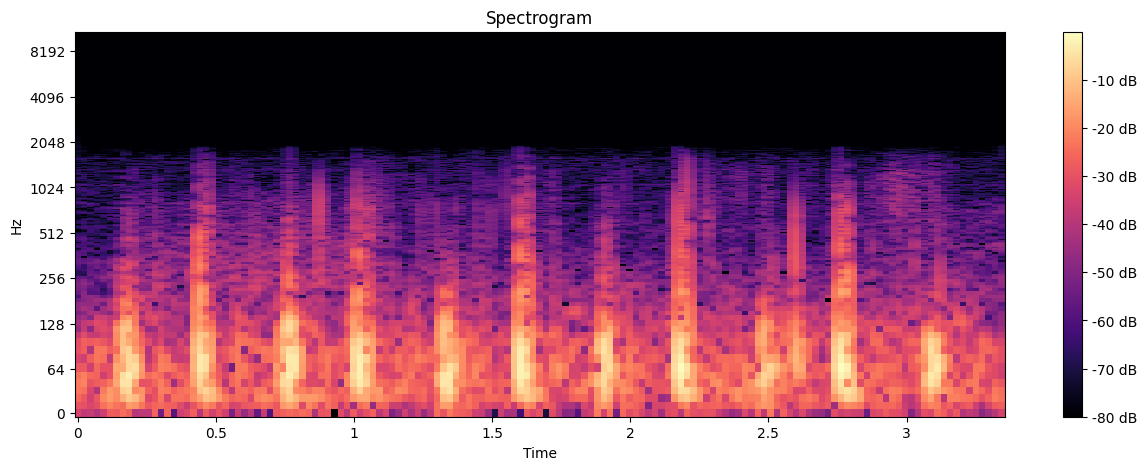

In [17]:
sample_extrastole_audio, sample_extrastole_label, sample_extrastole_sound, sample_extrastole_rate = visualize_random_extrastole_sample(df)

if sample_extrastole_audio is not None:
    display(sample_extrastole_audio)  
    plot_waveform(sample_extrastole_sound, sample_extrastole_rate) 
    plot_spectrum(sample_extrastole_sound, sample_extrastole_rate)  
    plot_spectrogram(sample_extrastole_sound, sample_extrastole_rate)  

In [18]:
def visualize_random_artifact_sample(df):
    artifact_df = df[df['Label'] == 'artifact']
    
    if artifact_df.empty:
        print("Tidak ada data dengan label 'artifact'.")
        return None, None, None
    
    random_index = np.random.randint(0, len(artifact_df))
    random_row = artifact_df.iloc[random_index]
    sample_label = random_row['Label']
    sample_file_name = random_row['FileName']
    sample_address = os.path.join(folder_path, sample_file_name)
    sample_sound, sample_rate = librosa.load(sample_address)
    sample_audio = ipd.Audio(sample_sound, rate=sample_rate)
    
    return sample_audio, sample_label, sample_sound, sample_rate

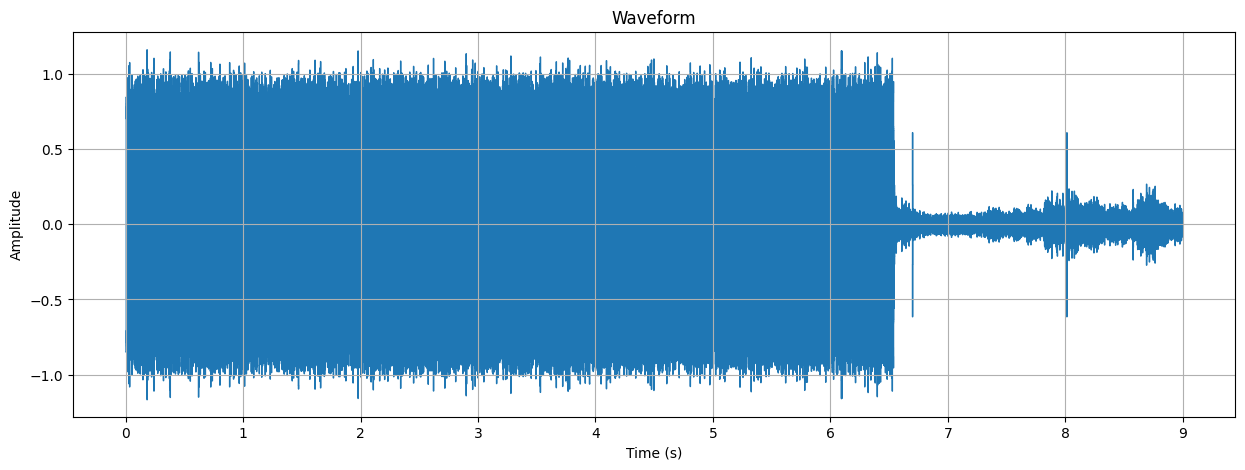

In [19]:
sample_artifact_audio, sample_artifact_label, sample_artifact_sound, sample_artifact_rate = visualize_random_artifact_sample(df)

if sample_artifact_audio is not None:
    display(sample_artifact_audio)  
    plot_waveform(sample_artifact_sound, sample_artifact_rate)  
    plot_spectrum(sample_artifact_sound, sample_artifact_rate)  
    plot_spectrogram(sample_artifact_sound, sample_artifact_rate)  

## PEMODELAN DENGAN MFCC DAN SMOTE

In [20]:
mfcc_features = []
for index, row in df.iterrows():
    file_path = os.path.join(folder_path, row['FileName'])
    y, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_features.append(mfcc_mean)

df_mfcc = pd.DataFrame(mfcc_features)

scaler = StandardScaler()
mfcc_scaled = scaler.fit_transform(df_mfcc)
df_mfcc_scaled = pd.DataFrame(mfcc_scaled, columns=[f'MFCC_{i+1}' for i in range(df_mfcc.shape[1])])
df_mfcc_scaled['Label'] = df['Label'].values


In [21]:
print("Distribusi label sebelum SMOTE:")
print(df['Label'].value_counts())

X = df_mfcc_scaled.drop(columns=['Label'])  
y = df_mfcc_scaled['Label']  

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Label'] = y_resampled

print("\nDistribusi label setelah SMOTE:")
print(df_resampled['Label'].value_counts())

Distribusi label sebelum SMOTE:
Label
normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: count, dtype: int64

Distribusi label setelah SMOTE:
Label
artifact      351
extrahls      351
extrastole    351
murmur        351
normal        351
Name: count, dtype: int64


In [ ]:
X = df_resampled.drop(columns=['Label'])  
y = df_resampled['Label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

total_data = len(df_resampled)
train_size = len(X_train_val)
val_size = len(X_val)
test_size = len(X_test)

print(f"Persentase data Train: {train_size / total_data * 100:.2f}%")
print(f"Persentase data Validation: {val_size / total_data * 100:.2f}%")
print(f"Persentase data Test: {test_size / total_data * 100:.2f}%")

model = RandomForestClassifier(random_state=42)
model.fit(X_train_val, y_train_val)

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)


Persentase data Train: 63.99%
Persentase data Validation: 16.01%
Persentase data Test: 20.00%



Confusion Matrix (Validation Set):


<Figure size 800x600 with 0 Axes>

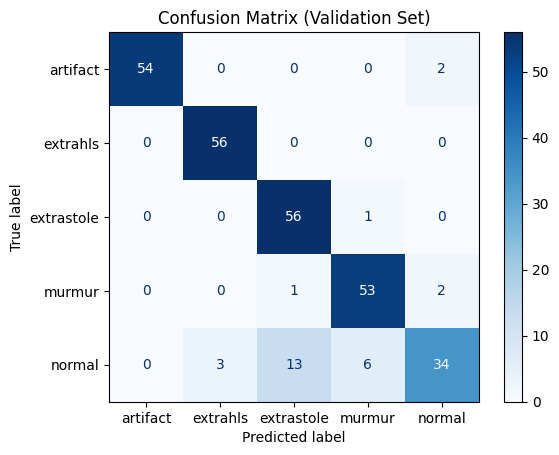


Classification Report (Validation Set):
              precision    recall  f1-score   support

    artifact       1.00      0.96      0.98        56
    extrahls       0.95      1.00      0.97        56
  extrastole       0.80      0.98      0.88        57
      murmur       0.88      0.95      0.91        56
      normal       0.89      0.61      0.72        56

    accuracy                           0.90       281
   macro avg       0.91      0.90      0.89       281
weighted avg       0.91      0.90      0.89       281



In [23]:
print("\nConfusion Matrix (Validation Set):")
val_cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=model.classes_)
disp_val.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))


Confusion Matrix (Test Set):


<Figure size 800x600 with 0 Axes>

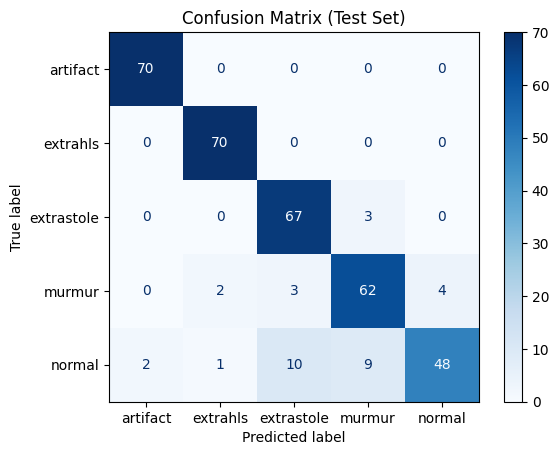


Classification Report (Test Set):
              precision    recall  f1-score   support

    artifact       0.97      1.00      0.99        70
    extrahls       0.96      1.00      0.98        70
  extrastole       0.84      0.96      0.89        70
      murmur       0.84      0.87      0.86        71
      normal       0.92      0.69      0.79        70

    accuracy                           0.90       351
   macro avg       0.91      0.90      0.90       351
weighted avg       0.91      0.90      0.90       351



In [24]:
print("\nConfusion Matrix (Test Set):")
test_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
disp_test.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.show()

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

## PEMODELAN DENGAN AUGMENTASI DATA, CLASS WEIGHT, DAN MFCC

In [34]:
processed_audio_features = []
labels = []
minority_classes = ['extrastole', 'artifact', 'extrahls']

def augment_audio(y, sr):
    if random.choice([True, False]):
        shift = random.randint(-1000, 1000) 
    
    if random.choice([True, False]):
        y = y * random.uniform(0.7, 1.3)  

    if random.choice([True, False]):
        pitch_shift = random.randint(-3, 3)  
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_shift)

    if random.choice([True, False]):
        noise = np.random.randn(len(y))
        y = y + 0.005 * noise  

    return y

In [37]:
for index, row in df.iterrows():
    file_path = os.path.join(folder_path, row['FileName'])
    y, sr = librosa.load(file_path)
    y_normalized = y / np.max(np.abs(y))
    mfcc = librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    processed_audio_features.append(mfcc_mean)
    labels.append(row['Label'])

    if row['Label'] in minority_classes:
        for _ in range(2): 
            y_augmented = augment_audio(y_normalized, sr)
            mfcc_augmented = librosa.feature.mfcc(y=y_augmented, sr=sr, n_mfcc=13)
            mfcc_mean_augmented = np.mean(mfcc_augmented, axis=1)
            processed_audio_features.append(mfcc_mean_augmented)
            labels.append(row['Label'])  

df_processed_mfcc = pd.DataFrame(processed_audio_features)
df_processed_mfcc['Label'] = labels


In [38]:
df_processed_mfcc['Label'].value_counts()

Label
normal        351
extrastole    138
murmur        129
artifact      121
extrahls       57
Name: count, dtype: int64

In [41]:
X = df_processed_mfcc.drop(columns=['Label'])  
y = df_processed_mfcc['Label']  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)



In [44]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data validasi:", X_val.shape[0])
print("Jumlah data uji:", X_test.shape[0])

Jumlah data latih: 473
Jumlah data validasi: 84
Jumlah data uji: 239


In [ ]:
rf_model = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)

rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)


In [49]:
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_val, display_labels=label_encoder.classes_)
plt.figure(figsize=(8, 8))
disp_val.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Validation Data")
plt.show()

              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00        13
    extrahls       0.71      0.83      0.77         6
  extrastole       0.88      0.50      0.64        14
      murmur       0.70      0.50      0.58        14
      normal       0.74      0.92      0.82        37

    accuracy                           0.79        84
   macro avg       0.81      0.75      0.76        84
weighted avg       0.79      0.79      0.77        84



<Figure size 800x800 with 0 Axes>

In [50]:
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=label_encoder.classes_)
plt.figure(figsize=(8, 8))
disp_test.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Data")
plt.show()


              precision    recall  f1-score   support

    artifact       0.87      0.94      0.91        36
    extrahls       0.65      0.76      0.70        17
  extrastole       1.00      0.69      0.82        42
      murmur       0.80      0.41      0.54        39
      normal       0.72      0.90      0.80       105

    accuracy                           0.78       239
   macro avg       0.81      0.74      0.75       239
weighted avg       0.80      0.78      0.77       239



<Figure size 800x800 with 0 Axes>